# Discretization of droop results

The model setup for the iterative discretization of droop results presented below is available in the following formats:

- pyshop
    - [discrete_droop.py](#discrete_droop.py)
- YAML
    - [model.yaml](#model.yaml)
    - [reserve_obligation.yaml](#reserve_obligation.yaml)
    - [discrete_droop_input.yaml](#discrete_droop_input.yaml)
- ASCII
    - [model.ascii](#model.ascii)
    - [reserve_obligation.ascii](#reserve_obligation.ascii)    
    - [discrete_droop_input.ascii](#discrete_droop_input.ascii)

## Iterative droop discretization
A simple system with 6 generators located on two separate plants will be used to illustrate the basic features of the droop discretization heuristic in SHOP. The droop variable is a continuous variable in SHOP, but there is usually a set of discrete droop values that can be implemented in the real world. The discrete droop functionality in SHOP enables the user to specify a set of discrete legal values that the droop variable in SHOP will be rounded and fixed to in the next iteration(s). This is a heuristic approach to the problem, since the droop variables are not formulated as discrete variables in the optimization problem. This would require the use of extra binary variables that will impact the tractability and calculation time of SHOP. Note that the droop discretization functionality requires the **SHOP_DISCRETE_DROOP** license.

First, we create and run the basic model without any droop discretization:

In [1]:
#Necessary imports used in all examples
import pandas as pd
import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go
cf.go_offline()
py.offline.init_notebook_mode(connected=True)
from pyshop import ShopSession

#Functions used in this example for building and solving a simple model with cuts
from discrete_droop import build_model, run_model, get_gen_droop

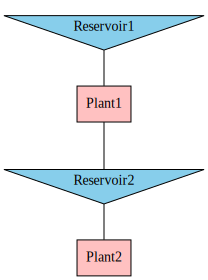

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with two reservoirs, two plants, and 6 generators.
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

#Add FCR_N obligation in both directions where all generators can participate
fcr_group = shop.model.reserve_group.add_object("fcr_group")
fcr_group.fcr_n_up_obligation.set(20)
fcr_group.fcr_n_down_obligation.set(20)    

for gen in shop.model.generator:
    fcr_group.connect_to(gen) 

#Run an optimization without any droop discretization
run_model(shop)

The resulting droop values can now be plotted. Note that the plotting below removes the time information form the droop values and plots them for the same x value:

In [3]:
#Display the resulting droop values from the optimization

#Retrieve the generator droop results
gen_droop = get_gen_droop(shop)

gen_names = [gen.get_name() for gen in shop.model.generator]

fig = go.Figure(layout={'title':"Droop values",'xaxis_title':"Generator",'yaxis_title':"Droop [%]"})

#Add dashed lines to show the integer values between 1 and 12
for i in range(1,13):
    fig.add_trace(go.Scatter(showlegend=False,x=gen_names,y=[i]*len(gen_names),mode='lines', line={'color': "black", 'width': 0.5,'dash':"dash"})) 
           
for gen_name, droop in gen_droop.items():
    fig.add_trace(go.Scatter(showlegend=False,x=[gen_name]*len(droop),y=droop,mode='markers')) 

fig.show()

The optimized droop values shown above are not necessarily legal or practical to implement in the real world. It is possible to round down and fix the droop values to the closest legal discrete value in SHOP. Each unit can have its own list of legal droop values specified by the double_array attribute **discrete_droop_values**. If no list is defined, the integers are assumed to be the legal values for the unit. The command `set droop_discretization_limit <value>`, or the equivalent double attribute **droop_discretization_limit** on the global_setting object, is used to tell SHOP to round *down* all droop values *below* the specified limit to their closest legal value, and fix the droop varaible to this value in the next iteration. Since the values are always rounded down, the generators are forced to deliver more (or equal) frequency response compared to the optimal solution. This can lead to a more costly solution, but will not cause infeasibility issues. If a unit has no legal discrete values below the given droop_discretization_limit, the droop will not be fixed. The droop variables will also never be fixed to a value outside its upper and lower bounds. These bounds have default values of 1 and 12, respectively, and can be changed by specifying the **droop_min** and **droop_max** TXY unit attributes. If the rounded droop value is outside the defined limits, it is fixed to the boundary instead.

Now we create an identical SHOP model but add specified legal discrete droop values for the generators in Plant2. By gradually increasing the droop_discretization_limit between the incremental iterations, the droop values are iteratively fixed to legal values.

In [4]:
#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with two reservoirs, two plants, and 6 generators.
build_model(shop)

#Add FCR_N obligation in both directions where all generators can participate
fcr_group = shop.model.reserve_group.add_object("fcr_group")
fcr_group.fcr_n_up_obligation.set(20)
fcr_group.fcr_n_down_obligation.set(20)    

for gen in shop.model.generator:
    fcr_group.connect_to(gen) 

#Set specific legal discrete droop values for generators in Plant2 (1,1.5,2,2.5,...,12)
plant2 = shop.model.plant.Plant2
for gen in plant2.generators:
    gen.discrete_droop_values.set([1+0.5*i for i in range(23)])
    
#Run the full iterations and the first incremental iteration without any fixing and discretization
shop.start_sim([], ['3'])
shop.set_code(['incremental'], [])
shop.start_sim([], ['1'])

#Save the droop results before any fixing and discretization
gen_droop = get_gen_droop(shop)
droop_results = [gen_droop]

#Gradually fix droop values for each following iteration
for d in [3,6,9,12]:
    shop.set_droop_discretization_limit([],[d])
    shop.start_sim([], ['1'])
    
    #Save the droop results for each generator after each iteration
    gen_droop = get_gen_droop(shop)        
    droop_results.append(gen_droop)

Now we can plot the evolution of the droop results for each generator for the four final incremental iterations:

In [5]:
for desc,gen_droop in zip(["before fixing","fixed below 3","fixed below 6","fixed below 9","fixed below 12"], droop_results):

    fig = go.Figure(layout={'title':f"Droop values {desc}",'xaxis_title':"Generator",'yaxis_title':"Droop [%]"})

    for i in range(1,13):
        fig.add_trace(go.Scatter(showlegend=False,x=gen_names,y=[i]*len(gen_names),mode='lines', line={'color': "black", 'width': 0.5,'dash':"dash"})) 

    for i in range(11):
        fig.add_trace(go.Scatter(showlegend=False,x=["Plant2_G1","Plant2_G4"],y=[1.5+i,1.5+i],mode='lines', line={'color': "red", 'width': 0.5,'dash':"dash"})) 

        
    for gen_name,droop_values in gen_droop.items():
        fig.add_trace(go.Scatter(showlegend=False,x=[gen_name]*len(droop_values),y=droop_values,mode='markers')) 

    fig.show()

Since the default upper bound for the droop is 12 in SHOP, all droop values are rounded and fixed when the discretization limit is set to 12 before the final iteration. The droop values of the generators in Plant1 are all fixed to integer values in the end, while the generators in Plant2 are allowed to take values defined earlier with the discrete_droop_values attribute.

## discrete_droop.py <a name="discrete_droop.py"></a>

In [6]:
%pycat discrete_droop.py

import pandas as pd
import numpy as np

def build_model(shop):
    starttime = pd.Timestamp('2018-01-23 00:00:00')
    endtime = pd.Timestamp('2018-01-26')
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour", timeresolution=pd.Series(index=[starttime],data=[1]))
    
    rsv1 = shop.model.reservoir.add_object('Reservoir1')
    rsv1.max_vol.set(39)
    rsv1.lrl.set(860)
    rsv1.hrl.set(905)
    rsv1.vol_head.set(pd.Series([860, 906, 907], index=[0, 39, 41.66], name=0))    

    rsv2 = shop.model.reservoir.add_object('Reservoir2')
    rsv2.max_vol.set(97.5)   
    rsv2.lrl.set(650)   
    rsv2.hrl.set(679)    
    rsv2.vol_head.set(pd.Series([650, 679, 680], index=[0, 97.5, 104.15], name=0))
    
    plant1 = shop.model.plant.add_object('Plant1')
    plant1.outlet_line.set(672)
    plant1.main_loss.set([0])
    plant1.penstock_loss.set([0.001])
    plant1.mip_flag.set(1)
    for gen_no in range(2):
        gen=shop.model.generator.add_object(f"{plant1.get_

## model.yaml <a name="model.yaml"></a>

In [7]:
%pycat model.yaml

time:
  starttime: 2018-01-23 00:00:00
  endtime: 2018-01-26 00:00:00
  timeunit: hour
  timeresolution:
    2018-01-23 00:00:00: 1
model:
  global_settings:
    global_settings:
      mipgap_rel: 0
      mipgap_abs: 0
  reservoir:
    Reservoir1:
      max_vol: 39
      lrl: 860
      hrl: 905
      vol_head:
        ref: 0
        x:
          - 0
          - 39
          - 41.66
        y:
          - 860
          - 906
          - 907
      start_head: 900
      energy_value_input: 30
    Reservoir2:
      max_vol: 97.5
      lrl: 650
      hrl: 679
      vol_head:
        ref: 0
        x:
          - 0
          - 97.5
          - 104.15
        y:
          - 650
          - 679
          - 680
      start_head: 670
      inflow:
        2018-01-23 00:00:00: 60
      energy_value_input: 10
  plant:
    Plant1:
      outlet_line: 672
      main_loss:
        - 0
      penstock_loss:
        - 0.001
      mip_flag:
        2018-01-23 00:00:00: 1
    Plant2:
      outlet_line: 586

## reserve_obligation.yaml <a name="reserve_obligation.yaml"></a>

In [8]:
%pycat reserve_obligation.yaml

model:
  reserve_group:
    fcr_group:
      fcr_n_up_obligation:
        2018-01-23 00:00:00: 20
      fcr_n_down_obligation:
        2018-01-23 00:00:00: 20
connections:
  - from: fcr_group
    to: Plant1_G1
  - from: fcr_group
    to: Plant1_G2
  - from: fcr_group
    to: Plant2_G1
  - from: fcr_group
    to: Plant2_G2
  - from: fcr_group
    to: Plant2_G3
  - from: fcr_group
    to: Plant2_G4


## discrete_droop_input.yaml <a name="discrete_droop_input.yaml"></a>

In [9]:
%pycat discrete_droop_input.yaml

model:
  generator:
    Plant2_G1:
      discrete_droop_values:
        - 1
        - 1.5
        - 2
        - 2.5
        - 3
        - 3.5
        - 4
        - 4.5
        - 5
        - 5.5
        - 6
        - 6.5
        - 7
        - 7.5
        - 8
        - 8.5
        - 9
        - 9.5
        - 10
        - 10.5
        - 11
        - 11.5
        - 12
    Plant2_G2:
      discrete_droop_values:
        - 1
        - 1.5
        - 2
        - 2.5
        - 3
        - 3.5
        - 4
        - 4.5
        - 5
        - 5.5
        - 6
        - 6.5
        - 7
        - 7.5
        - 8
        - 8.5
        - 9
        - 9.5
        - 10
        - 10.5
        - 11
        - 11.5
        - 12
    Plant2_G3:
      discrete_droop_values:
        - 1
        - 1.5
        - 2
        - 2.5
        - 3
        - 3.5
        - 4
        - 4.5
        - 5
        - 5.5
        - 6
        - 6.5
        - 7
        - 7.5
        - 8
        - 8.5
        - 9
        - 9.5
        

## model.ascii <a name="model.ascii"></a>

In [10]:
%pycat model.ascii

#;
# Name of the datafile is: model.ascii;
#;

SIZE
#Num_reservoirs;Num_plants;Num_gates;Num_junctions
2            2          0           0

OPTIMIZATION time
#Start_time;   End_time;
20180123000000 20180126000000

#;N_full_iterations;Accuracy;
OPTIMIZATION   1000       1.00
#Time resolution in the optimization;
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
0      0 20180123000000000 HOUR      0     -1 NO_UNIT     73
#            Time;      f(t);
20180123000000000 1.00000000000000000

GLOBAL_SETTINGS mipgap_rel
# relative mipgap for the optimization;
0.000000

GLOBAL_SETTINGS mipgap_abs
# absolute mipgap_unit for the optimization;
0.000000

RESERVOIR attributes Reservoir1
#ID;Water_course;Type;Maxvol;Lrl;Hrl;
0      0      0     39.000    860.000    905.000

RESERVOIR vol_head Reservoir1
#Id;Number;Reference;Pts;X_unit;Y_unit
0      0       0.00      3 MM3 METER
#  x_value;   y_value;
0.0000000000 860.0000000000
39.0000000000 906.0000000000
41.6600000000 907.0000000000


## reserve_obligation.ascii <a name="reserve_obligation.ascii"></a>

In [11]:
%pycat reserve_obligation.ascii

RESERVE_GROUP   fcr_n_up        1
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
0      0 20180123000000000 HOUR      0     -1 MW     1
#            Time;      f(t);
20180123000000000 20.0

RESERVE_GROUP   fcr_n_down      1
#Id;Number;Start_Time;Time_unit;Period;Data_type;Y_unit;Pts;
0      0 20180123000000000 HOUR      0     -1 MW     1
#            Time;      f(t);
20180123000000000 20.0


#FCR-N UP
GENERATOR       gen_fcr_n_up_group      Plant1      1
#       Id      number  starttime               time_unit       period  data_type       y_unit  npts
0       0       20190913060000000       HOUR            8760            -1      NO_UNIT 1
#       time            y
20190913060000000       1.000000000000

GENERATOR       gen_fcr_n_up_group      Plant1      2
#       Id      number  starttime               time_unit       period  data_type       y_unit  npts
0       0       20190913060000000       HOUR            8760            -1      NO_UNIT 1
#       time            y

## discrete_droop_input.ascii <a name="discrete_droop_input.ascii"></a>

In [12]:
%pycat discrete_droop_input.ascii

GENERATOR       discrete_droop_values   Plant2      1
1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0

GENERATOR       discrete_droop_values   Plant2      2
1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0

GENERATOR       discrete_droop_values   Plant2      3
1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0

GENERATOR       discrete_droop_values   Plant2      4
1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0
